In [8]:
import pandas as pd
import numpy as np

from model import plot_kaplanmeier
from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter
from auton_survival.preprocessing import Preprocessor

In [9]:
bari2d_phenotypes = pd.read_csv('./Bari2D_phenotypes.csv')
sts_phenotypes = pd.read_csv('./STS_phenotypes.csv')

bari2d_outcomes_p1 = bari2d_phenotypes[bari2d_phenotypes.phenotypes==0][['time', 'event', 'intervention']]
bari2d_groups_p1 = bari2d_outcomes_p1['intervention']
bari2d_outcomes_p1.drop(columns=['intervention'], inplace=True)

bari2d_outcomes_p2 = bari2d_phenotypes[bari2d_phenotypes.phenotypes==1][['time', 'event', 'intervention']]
bari2d_groups_p2 = bari2d_outcomes_p2['intervention']
bari2d_outcomes_p2.drop(columns=['intervention'], inplace=True)

sts_outcomes = sts_phenotypes[['time', 'event']]
sts_outcomes_p1 = sts_phenotypes[sts_phenotypes.phenotypes==0][['time', 'event']]
sts_outcomes_p2 = sts_phenotypes[sts_phenotypes.phenotypes==1][['time', 'event']]


In [10]:
def fix_nan(x, cat_feats, num_feats):
    preprocessor = Preprocessor(cat_feat_strat='ignore', num_feat_strat='mean')
    preprocessor = preprocessor.fit(x[cat_feats + num_feats], cat_feats=cat_feats, num_feats=num_feats,vone_hot=True, fill_value=-1)
    processed = preprocessor.transform(x[cat_feats + num_feats]).astype(float)   
    
    return processed

In [11]:
# The log-rank test is a statistical hypothesis test used to compare the 
# survival distributions of two groups (e.g., control vs. treatment) based 
# on their Kaplan-Meier survival curves. Its used to assess whether there 
# is a statistically significant difference between the survival experiences 
# of different groups over time.

# BARI2D Treatment Group Comparison
bari2d_cat_feats = ['hxchl', 'ablvef', 'hxetoh', 'hxmi', 'hxchf', 'hxhtn', 'sex', 'smkcat', 
                     'race', 'hispanic', 'intervention']
bari2d_num_feats = ['screat', 'hba1c', 'bmi', 'age']

p1 = bari2d_phenotypes[bari2d_phenotypes['phenotypes']==0].reset_index(drop=True)
p1_fill= fix_nan(p1, bari2d_cat_feats, bari2d_num_feats).reset_index(drop=True)
p1_fill = pd.concat([p1[['time', 'event']], p1_fill], axis=1)
cph1 = CoxPHFitter().fit(p1_fill.reset_index(drop=True), 'time', 'event')
p1_hr = round(cph1.summary['exp(coef)']['intervention_1.0'], 3)
p1_hr_lower = round(cph1.summary['exp(coef) lower 95%']['intervention_1.0'], 3)
p1_hr_upper = round(cph1.summary['exp(coef) upper 95%']['intervention_1.0'], 3)
p1_hr_txt = str(p1_hr) + ' ('+ str(p1_hr_lower)+', '+ str(p1_hr_upper) +')'

bari2d_p1_pval = logrank_test(durations_A=p1.loc[p1.intervention==0]['time'],
                              durations_B=p1.loc[p1.intervention==1]['time'],
                              event_observed_A=p1.loc[p1.intervention==0]['event'],
                              event_observed_B=p1.loc[p1.intervention==1]['event'],
                              ).p_value
        
p2 = bari2d_phenotypes[bari2d_phenotypes['phenotypes']==1].reset_index(drop=True)
p2_fill= fix_nan(p2, bari2d_cat_feats, bari2d_num_feats).reset_index(drop=True)
p2_fill = pd.concat([p2[['time', 'event']], p2_fill], axis=1)
cph2 = CoxPHFitter().fit(p2_fill.reset_index(drop=True), 'time', 'event')
p2_hr = round(cph2.summary['exp(coef)']['intervention_1.0'], 3)
p2_hr_lower = round(cph2.summary['exp(coef) lower 95%']['intervention_1.0'], 3)
p2_hr_upper = round(cph2.summary['exp(coef) upper 95%']['intervention_1.0'], 3)
p2_hr_txt = str(p2_hr) + ' ('+ str(p2_hr_lower)+', '+ str(p2_hr_upper) +')'

bari2d_p2_pval = logrank_test(durations_A=p2.loc[p2.intervention==0]['time'],
                              durations_B=p2.loc[p2.intervention==1]['time'],
                              event_observed_A=p2.loc[p2.intervention==0]['event'],
                              event_observed_B=p2.loc[p2.intervention==1]['event'],
                             ).p_value


# BARI2D Phenotype (Treatment) Group Comparison
bari2d_cat_feats = ['hxchl', 'ablvef', 'hxetoh', 'hxmi', 'hxchf', 'hxhtn', 'sex', 'smkcat', 
                     'race', 'hispanic', 'phenotypes']
bari2d_num_feats = ['screat', 'hba1c', 'bmi', 'age']

p3 = bari2d_phenotypes[bari2d_phenotypes['intervention']==1].reset_index(drop=True)
p3_fill= fix_nan(p3, bari2d_cat_feats, bari2d_num_feats).reset_index(drop=True)
p3_fill = pd.concat([p3[['time', 'event']], p3_fill], axis=1)
cph3 = CoxPHFitter().fit(p3_fill.reset_index(drop=True), 'time', 'event')
p3_hr = round(cph3.summary['exp(coef)']['phenotypes_1'], 3)
p3_hr_lower = round(cph3.summary['exp(coef) lower 95%']['phenotypes_1'], 3)
p3_hr_upper = round(cph3.summary['exp(coef) upper 95%']['phenotypes_1'], 3)
p3_hr_txt = str(p3_hr) + ' ('+ str(p3_hr_lower)+', '+ str(p3_hr_upper) +')'

bari2d_treatment_pval = logrank_test(durations_A=p3.loc[p3.phenotypes==0]['time'],
                                     durations_B=p3.loc[p3.phenotypes==1]['time'],
                                     event_observed_A=p3.loc[p3.phenotypes==0]['event'],
                                     event_observed_B=p3.loc[p3.phenotypes==1]['event'],
                                    ).p_value


# STS Phenotype (Treatment) Group Comparison
sts_cat_feats = ['phenotypes', 'dyslip', 'hdef', 'alcohol','prevmi', 'chf', 'hypertn', 
                 'female', 'recentishsmoker', 'racecaucasian', 'ethnicity']
sts_num_feats = ['creatlst', 'a1clvl', 'bmi', 'age']

sts_fill= fix_nan(sts_phenotypes, sts_cat_feats, sts_num_feats).reset_index(drop=True)
sts_fill = pd.concat([sts_phenotypes[['time', 'event']], sts_fill], axis=1)
sts_cph = CoxPHFitter().fit(sts_fill.reset_index(drop=True), 'time', 'event')
sts_hr = round(sts_cph.summary['exp(coef)']['phenotypes_1'], 3)
sts_hr_lower = round(sts_cph.summary['exp(coef) lower 95%']['phenotypes_1'], 3)
sts_hr_upper = round(sts_cph.summary['exp(coef) upper 95%']['phenotypes_1'], 3)
sts_hr_txt = str(sts_hr) + ' ('+ str(sts_hr_lower)+', '+ str(sts_hr_upper) +')'

sts_treatment_pval = logrank_test(durations_A=sts_phenotypes.loc[sts_phenotypes.phenotypes==0]['time'],
                                  durations_B=sts_phenotypes.loc[sts_phenotypes.phenotypes==1]['time'],
                                  event_observed_A=sts_phenotypes.loc[sts_phenotypes.phenotypes==0]['event'],
                                  event_observed_B=sts_phenotypes.loc[sts_phenotypes.phenotypes==1]['event'],
                                ).p_value

/zfsauton2/home/mingzhul/anaconda3/envs/heterogeniety/lib/python3.9/site-packages/lifelines/utils/__init__.py:997: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  nonnumeric_cols = [col for (col, dtype) in df.dtypes.iteritems() if dtype.name == "category" or dtype.kind not in "biuf"]
/zfsauton2/home/mingzhul/anaconda3/envs/heterogeniety/lib/python3.9/site-packages/lifelines/utils/__init__.py:997: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  nonnumeric_cols = [col for (col, dtype) in df.dtypes.iteritems() if dtype.name == "category" or dtype.kind not in "biuf"]
/zfsauton2/home/mingzhul/anaconda3/envs/heterogeniety/lib/python3.9/site-packages/lifelines/utils/__init__.py:997: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  nonnumeric_cols = [col for (col, dtype) in df.dtypes.iteritems() if dtype.name == "category" or dtype.kin

In [12]:

def plot_kaplanmeier(outcomes, groups=None, plot_counts=False, title=None, color='blue', ylabel=False, label=None, **kwargs):

    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams['font.family'] = 'serif'
    
    if groups is not None:
        curve1 = KaplanMeierFitter().fit(outcomes.loc[groups==1]['time'],
                                         outcomes.loc[groups==1]['event']
                                        )
        curve2 = KaplanMeierFitter().fit(outcomes.loc[groups==0]['time'],
                                         outcomes.loc[groups==0]['event']
                                        )
      
        ax = curve1.plot(label=label[0], ax=None, color=color, linewidth=2, linestyle='-', ci_show=False)
        ax = curve2.plot(label=label[1], ax=None, color=color, linewidth=3, linestyle=':', ci_show=False)

        plt.xlabel('Time (Years)', fontsize=26)
        ax.grid(True)
        ax.set_xlim([0, 11])
        ax.set_ylim([0.48, 1])
        ax.tick_params(axis="y", labelsize=26)
        ax.tick_params(axis="x", labelsize=26)
        
        # By default, we use the at-risk count from the end of the period. 
        if plot_counts[0]:
            xticks = np.array([0., 2., 4., 6., 8., 10., 11.])
            
            at_risk_table = curve1.event_table
            f = interp1d(at_risk_table.index.values, at_risk_table['at_risk'], 
                         kind='linear',
                         bounds_error=False, 
                         fill_value=500,
                        )
            at_risk_values = f(xticks)
            #at_risk_values = np.array([int(round(i)) for i in at_risk_values])
            #at_risk_values = np.where(at_risk_values==1000, '', at_risk_values)
            
            at_risk_table2 = curve2.event_table
            f2 = interp1d(at_risk_table2.index.values, at_risk_table2['at_risk'], 
                         kind='linear',
                         bounds_error=False, 
                         fill_value=500,
                        )
            at_risk_values2 = f2(xticks)
            
            at_risk_values = np.array([int(round(i))+int(round(j)) for i, j in zip(at_risk_values, at_risk_values2)])
            at_risk_values = np.where(at_risk_values==1000, '', at_risk_values)

            ax2 = ax.twiny()
            ax2.spines['bottom'].set_position(('outward', plot_counts[1]))  # 'outward' by 50 points
            ax2.xaxis.set_ticks_position('bottom')
            ax2.xaxis.set_label_position('bottom')
            ax2.set_xticks(xticks)
            ax2.set_xticklabels(at_risk_values, fontsize=26, color=plot_counts[2])
            ax2.set_xlabel('At Risk', fontsize=26)
            ax2.grid(False)
        
    else:
        curve1 = KaplanMeierFitter().fit(outcomes['time'],
                                         outcomes['event']
                                        )
        ax = curve1.plot(label=label, ax=None, color=color, linewidth=2, linestyle='-', ci_show=False)
        plt.xlabel('Time (Years)', fontsize=26)
        ax.grid(True)
        ax.set_xlim([0, 11])
        ax.set_ylim([0.48, 1])
        ax.tick_params(axis="y", labelsize=26)
        ax.tick_params(axis="x", labelsize=26)
        
        # By default, we use the at-risk count from the end of the period. 
        if plot_counts[0]:
            xticks = np.array([0., 2., 4., 6., 8., 10., 11.])
            at_risk_table = curve1.event_table
            f = interp1d(at_risk_table.index.values, at_risk_table['at_risk'], 
                         kind='linear',
                         bounds_error=False, 
                         fill_value=1000,
                        )
            at_risk_values = f(xticks)
            at_risk_values = np.array([int(round(i)) for i in at_risk_values])
            at_risk_values = np.where(at_risk_values==1000, '', at_risk_values)

            ax2 = ax.twiny()
            ax2.spines['bottom'].set_position(('outward', plot_counts[1]))  # 'outward' by 50 points
            ax2.xaxis.set_ticks_position('bottom')
            ax2.xaxis.set_label_position('bottom')
            ax2.set_xticks(xticks)
            ax2.set_xticklabels(at_risk_values, fontsize=26, color=plot_counts[2])
            ax2.set_xlabel('At Risk', fontsize=26)
            ax2.grid(False)
        
    plt.title(title, fontsize=26)    
        
    if ylabel:
        ax.set_ylabel('Survival Probability', fontsize=26)

    return ax


In [13]:
bari2d_outcomes_p1.loc[bari2d_groups_p1==0]

,time,event
13,3.619439,0.0
22,7.028063,0.0
31,3.408624,0.0
43,5.746749,0.0
54,3.633128,0.0
...,...,...
688,4.353183,1.0
701,3.712526,0.0
721,4.101300,0.0
738,6.124572,0.0


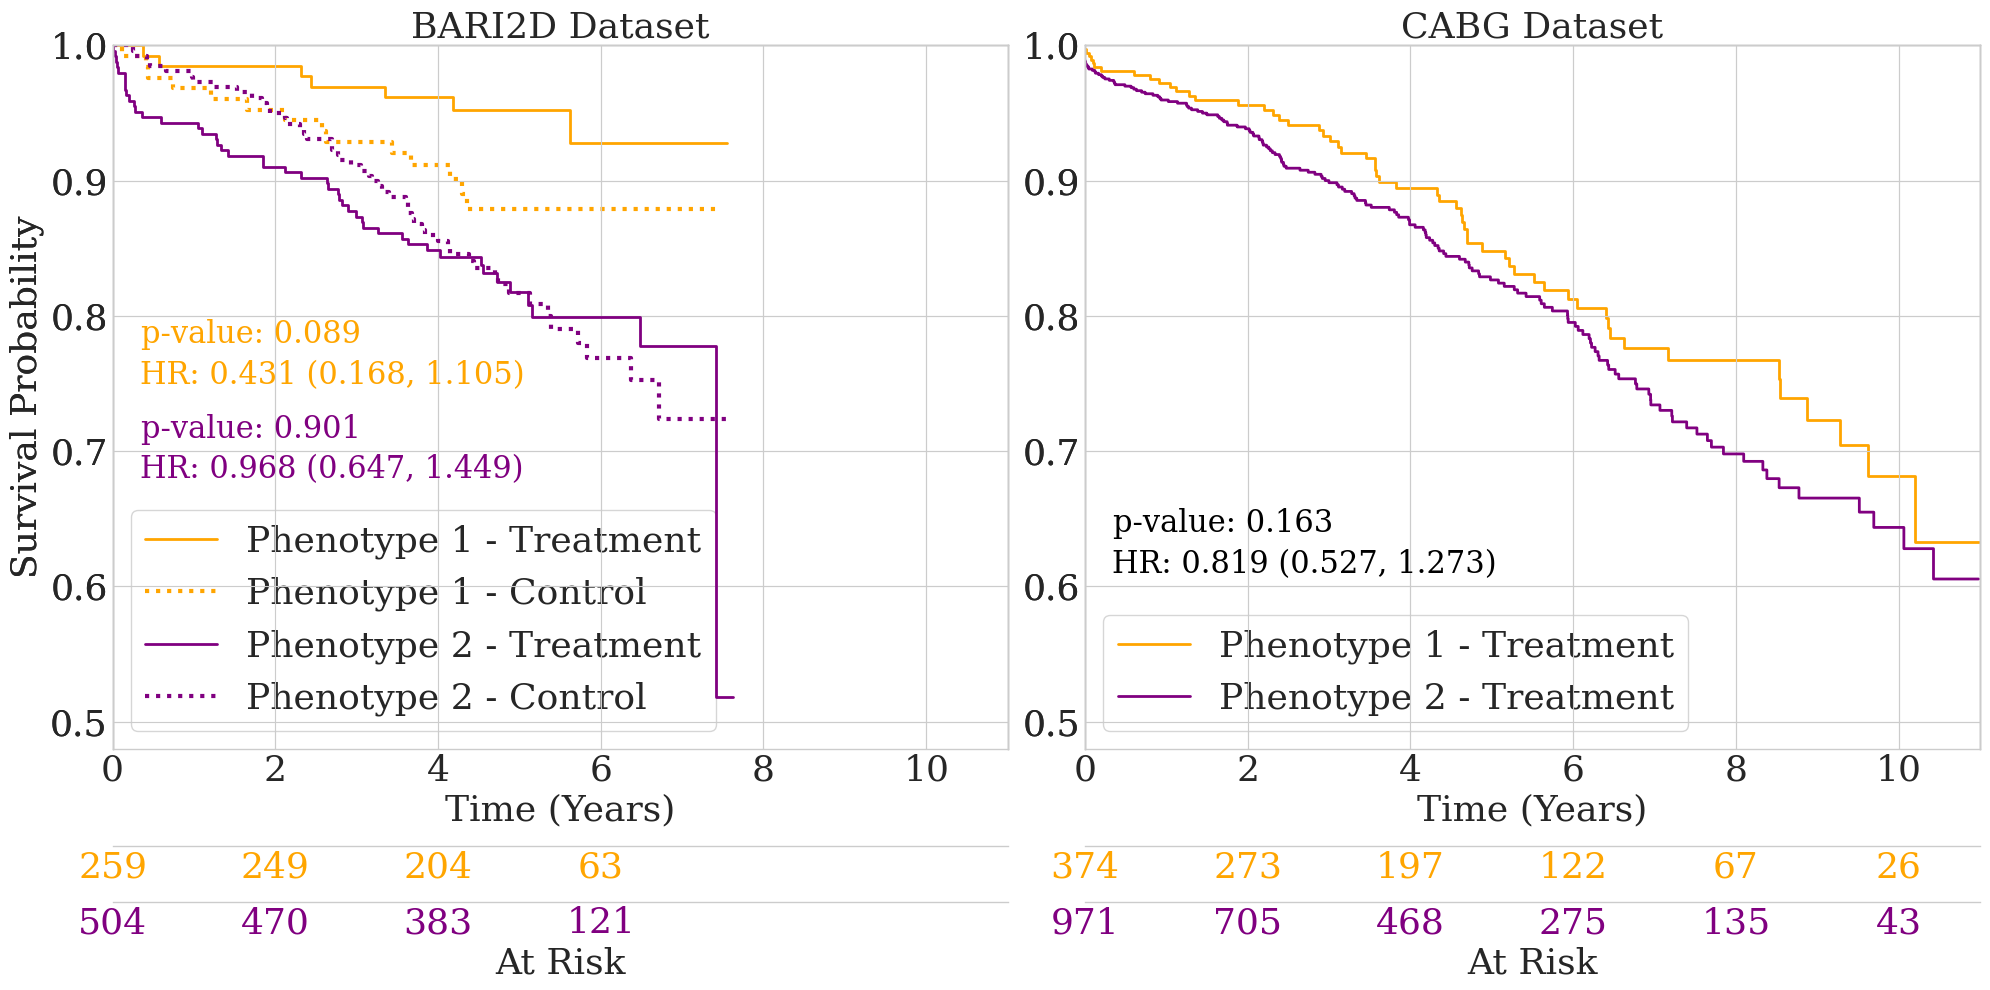

In [14]:
fig_combined = plt.figure(figsize=(20, 10))

ax1_combined = fig_combined.add_subplot(121) 
ax1 = plot_kaplanmeier(bari2d_outcomes_p1, 
                       groups=bari2d_groups_p1, 
                       plot_counts=[True, 70, 'orange'], 
                       #plot_counts=[False],
                       title='', 
                       color='orange', 
                       ylabel=True,
                       label=['Phenotype 1 - Treatment',
                              'Phenotype 1 - Control'],
                      )

ax2 = plot_kaplanmeier(bari2d_outcomes_p2, 
                       groups=bari2d_groups_p2, 
                       plot_counts=[True, 110, 'purple'], 
                       #plot_counts=[False],
                       title='BARI2D Dataset', 
                       color='purple', 
                       ylabel=True,
                       label=['Phenotype 2 - Treatment',
                              'Phenotype 2 - Control'],
                      )

plt.text(1.7, 0.78, 'p-value: '+str(round(bari2d_p1_pval, 3)), fontsize=22, color='orange', ha='center')
plt.text(2.7, 0.75, 'HR: '+p1_hr_txt, fontsize=22, color='orange', ha='center')

plt.text(1.7, 0.71, 'p-value: '+str(round(bari2d_p2_pval, 3)), fontsize=22, color='purple', ha='center')
plt.text(2.7, 0.68, 'HR: '+p2_hr_txt, fontsize=22, color='purple', ha='center')

#plt.text(1.6, 0.68, 'p-value: '+str(round(bari2d_treatment_pval, 3)), fontsize=22, color='black', ha='center')
#plt.text(2.6, 0.65, 'HR: '+p3_hr_txt, fontsize=22, color='black', ha='center')

ax2.set_xlabel('')

ax1.get_legend().remove()
ax2.get_legend().remove()
lines_labels = [ax.get_legend_handles_labels() for ax in [ax1, ax2]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
ax1.legend(lines[:4], labels, loc='lower left', fontsize=26, frameon=True)

ax3_combined = fig_combined.add_subplot(122) 
ax3 = plot_kaplanmeier(sts_outcomes_p1, 
                       groups=None, 
                       plot_counts=[True, 70, 'orange'],
                       #plot_counts=[False],
                       title='',
                       color='orange', 
                       ylabel=False,
                       label='Phenotype 1 - Treatment',
                      )

ax4 = plot_kaplanmeier(sts_outcomes_p2, 
                       groups=None, 
                       plot_counts=[True, 110, 'purple'], 
                       #plot_counts=[False],
                       title='CABG Dataset', 
                       color='purple', 
                       ylabel=False,
                       label='Phenotype 2 - Treatment'
                      )

plt.text(1.7, 0.64, 'p-value: '+str(round(sts_treatment_pval, 3)), fontsize=22, color='black', ha='center')
plt.text(2.7, 0.61, 'HR: '+sts_hr_txt, fontsize=22, color='black', ha='center')

ax4.set_xlabel('')

ax3.get_legend().remove()
ax4.get_legend().remove()

lines_labels = [ax.get_legend_handles_labels() for ax in [ax3, ax4]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
ax3.legend(lines[:2], labels, loc='lower left', fontsize=26, frameon=True)

plt.tight_layout()
plt.savefig('./kaplan_meier_curves2.png')